In [1]:
from gigamed.utils import PairedDataset
from torch.utils.data import Dataset, DataLoader
import torchio as tio

root_dir = '/midtier/sablab/scratch/alw4013/data/nnUNet_1mmiso_256x256x256_MNI_HD-BET_preprocessed/Dataset5000_BraTS-GLI_2023/'
dataset = PairedDataset(root_dir, train=True, include_lesion_seg=True)
dataloader = DataLoader(
                dataset,
                batch_size=1,
                shuffle=False,
                num_workers=0,
            )

In [2]:
from keymorph.net import ConvNet, UNet, RXFM_Net, TruncatedUNet
import torch
from keymorph.model import KeyMorph
from keymorph import utils
from torch_receptive_field import receptive_field, receptive_field_for_unit

dim = 3
num_keypoints = 256
num_truncated_layers_for_truncatedunet = 1
use_amp = True
max_train_keypoints = 32
weighted_kp_align = 'power'
device = 'cuda'
load_path = '/midtier/sablab/scratch/alw4013/keymorph/weights/truncatedunet1/__training__gigamed-weighted-lesion-normal-skullstrip-nonskullstrip-256_datasetgigamed_modelkeymorph_keypoints256_batch1_normTypeinstance_lr3e-06/checkpoints/epoch5000_trained_model.pth.tar'

def get_model():
    network = TruncatedUNet(
        dim,
        1,
        num_keypoints,
        num_truncated_layers_for_truncatedunet,
    )
    network = torch.nn.DataParallel(network)

    # Keypoint model
    registration_model = KeyMorph(
        network,
        num_keypoints,
        dim,
        use_amp=use_amp,
        max_train_keypoints=max_train_keypoints,
        weight_keypoints=weighted_kp_align,
    )
    registration_model.to(device)
    utils.summary(registration_model)

    return registration_model

registration_model = get_model()
optimizer = torch.optim.Adam(registration_model.parameters(), lr=1e-4)
ckpt_state, registration_model, optimizer = utils.load_checkpoint(
            load_path,
            registration_model,
            optimizer,
            device=device,
        )

registration_model.eval()


Model Summary
---------------------------------------------------------------
backbone.module.backbone.encoders.0.basic_module.SingleConv1.groupnorm.weight
backbone.module.backbone.encoders.0.basic_module.SingleConv1.groupnorm.bias
backbone.module.backbone.encoders.0.basic_module.SingleConv1.conv.weight
backbone.module.backbone.encoders.0.basic_module.SingleConv2.groupnorm.weight
backbone.module.backbone.encoders.0.basic_module.SingleConv2.groupnorm.bias
backbone.module.backbone.encoders.0.basic_module.SingleConv2.conv.weight
backbone.module.backbone.encoders.1.basic_module.SingleConv1.groupnorm.weight
backbone.module.backbone.encoders.1.basic_module.SingleConv1.groupnorm.bias
backbone.module.backbone.encoders.1.basic_module.SingleConv1.conv.weight
backbone.module.backbone.encoders.1.basic_module.SingleConv2.groupnorm.weight
backbone.module.backbone.encoders.1.basic_module.SingleConv2.groupnorm.bias
backbone.module.backbone.encoders.1.basic_module.SingleConv2.conv.weight
backbone.modu

KeyMorph(
  (backbone): DataParallel(
    (module): TruncatedUNet(
      (backbone): TruncatedUNet3D(
        (encoders): ModuleList(
          (0): Encoder(
            (basic_module): DoubleConv(
              (SingleConv1): SingleConv(
                (groupnorm): GroupNorm(1, 1, eps=1e-05, affine=True)
                (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
                (ReLU): ReLU(inplace=True)
              )
              (SingleConv2): SingleConv(
                (groupnorm): GroupNorm(8, 16, eps=1e-05, affine=True)
                (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
                (ReLU): ReLU(inplace=True)
              )
            )
          )
          (1): Encoder(
            (pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            (basic_module): DoubleConv(
              (SingleConv1): SingleConv(
             

In [5]:
from keymorph.cm_plotter import show_img_and_points
import matplotlib.pyplot as plt
import numpy as np

def remap_keypoints(keypoints, segmentation_shape):
    """
    Remap keypoints from [-1, 1]^3 to segmentation voxel space.
    
    Args:
    keypoints: NumPy array of shape (batch_size, N, 3), normalized keypoints.
    segmentation_shape: Tuple of 3 ints, shape of the segmentation (depth, height, width).
    
    Returns:
    Remapped keypoints in voxel space.
    """
    # Calculate scale factors for each dimension
    scale_factors = np.array(segmentation_shape) - 1
    
    # Remap from [-1, 1] to [0, scale_factor]
    remapped_keypoints = (keypoints + 1) / 2 * scale_factors
    
    # Ensure that keypoints do not exceed segmentation boundaries
    remapped_keypoints = np.clip(remapped_keypoints, 0, scale_factors)
    
    return remapped_keypoints.astype(int)

def lesion_seg_at_keypoint(keypoints, lesion_mask):
    keypoints = remap_keypoints(keypoints, (256, 256, 256))
    
    is_in_lesion = []
    for keypoint in keypoints:
        is_in_lesion.append(lesion_mask[keypoint[0], keypoint[1], keypoint[2]])
    
    return np.array(is_in_lesion)
        
transform_type = 'rigid'
in_lesions, out_lesions = [], []

for step_idx, (fixed, moving) in enumerate(dataloader):
    if step_idx == 10:
        break

    # Get images and segmentations from TorchIO subject
    img_f, img_m = fixed["img"][tio.DATA], moving["img"][tio.DATA]
    seg_f, seg_m = fixed["seg"][tio.DATA], moving["seg"][tio.DATA]
    lseg_f, lseg_m = fixed["lesion_seg"][tio.DATA], moving["lesion_seg"][tio.DATA]


    # Move to device
    img_f = img_f.float().to(device)
    img_m = img_m.float().to(device)
    seg_f = seg_f.float().to(device)
    seg_m = seg_m.float().to(device)


    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        registration_results = registration_model(
            img_f,
            img_m,
            transform_type=transform_type,
            return_aligned_points=True,
        )[transform_type]
        grid = registration_results["grid"]
        align_type = transform_type
        tps_lmbda = registration_results["tps_lmbda"]
        points_m = registration_results["points_m"].cpu().detach().numpy()
        points_f = registration_results["points_f"].cpu().detach().numpy()
        if "points_a" in registration_results:
            points_a = registration_results["points_a"].cpu().detach().numpy()
        points_weights = registration_results["points_weights"].cpu().detach().numpy()
        
        is_in_lesion = lesion_seg_at_keypoint(points_m[0], lseg_m[0, 0].cpu().detach().numpy())
        if is_in_lesion.sum() == 0:
            continue
        
        in_lesion_keypoints = is_in_lesion>0
        out_lesion_keypoints = is_in_lesion==0
        in_lesions += points_weights[0, in_lesion_keypoints].tolist()
        out_lesions += points_weights[0, out_lesion_keypoints].tolist()

        
#         print(in_lesions)
#         print(out_lesions)


        
        
#         show_img_and_points(img_f[0, 0].cpu().detach().numpy(), 
#                             points_f[0], 
#                             points_weights[0])
#         plt.show()
#         plt.imshow(lseg_m[0, 0, 128].cpu().detach().numpy())
#         plt.show()

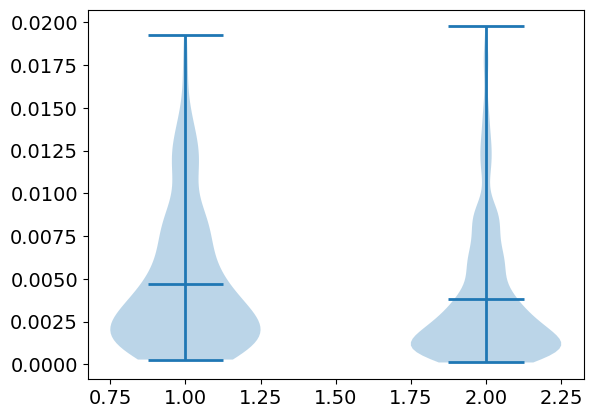

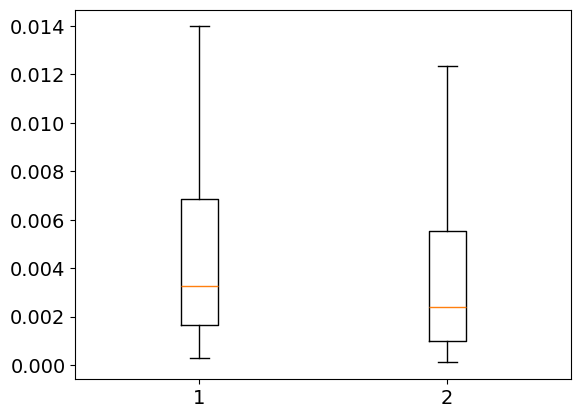

In [9]:
plt.violinplot([np.array(in_lesions), np.array(out_lesions)], showmeans=True)
plt.show()

plt.boxplot([np.array(in_lesions), np.array(out_lesions)], showfliers=False)
plt.show()